<a href="https://colab.research.google.com/github/Abhiii22/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install kaggle
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
!pip install seaborn

**Kaggle API Setup**

In [2]:
import os
from google.colab import files

# Upload your kaggle.json file
uploaded = files.upload()

# Create the kaggle directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Unzip the dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_data

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 130M/149M [00:00<00:00, 1.35GB/s]
100% 149M/149M [00:00<00:00, 1.28GB/s]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os
import random
from PIL import Image

**Data Preprocessing**

In [5]:
# Define image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Define paths
data_dir = '/content/brain_tumor_data'
training_dir = os.path.join(data_dir, 'Training')
testing_dir = os.path.join(data_dir, 'Testing')

# Get class names
class_names = sorted(os.listdir(training_dir))
print("Classes:", class_names)

# Function to load and preprocess images
def load_images(directory, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    images = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for image_file in os.listdir(class_dir):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(class_dir, image_file)

                # Read and preprocess image
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, img_size)
                image = image / 255.0  # Normalize pixel values

                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)

# Load training and testing data
print("Loading training images...")
X_train, y_train = load_images(training_dir)
print("Loading testing images...")
X_test, y_test = load_images(testing_dir)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Loading training images...
Loading testing images...
Training data shape: (5712, 128, 128, 3)
Testing data shape: (1311, 128, 128, 3)


**Exploratory Data Analysis**

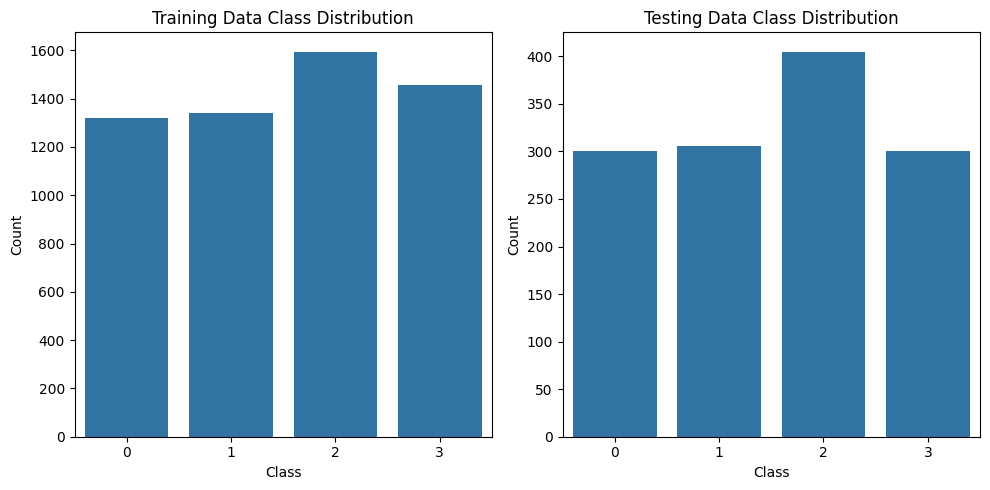

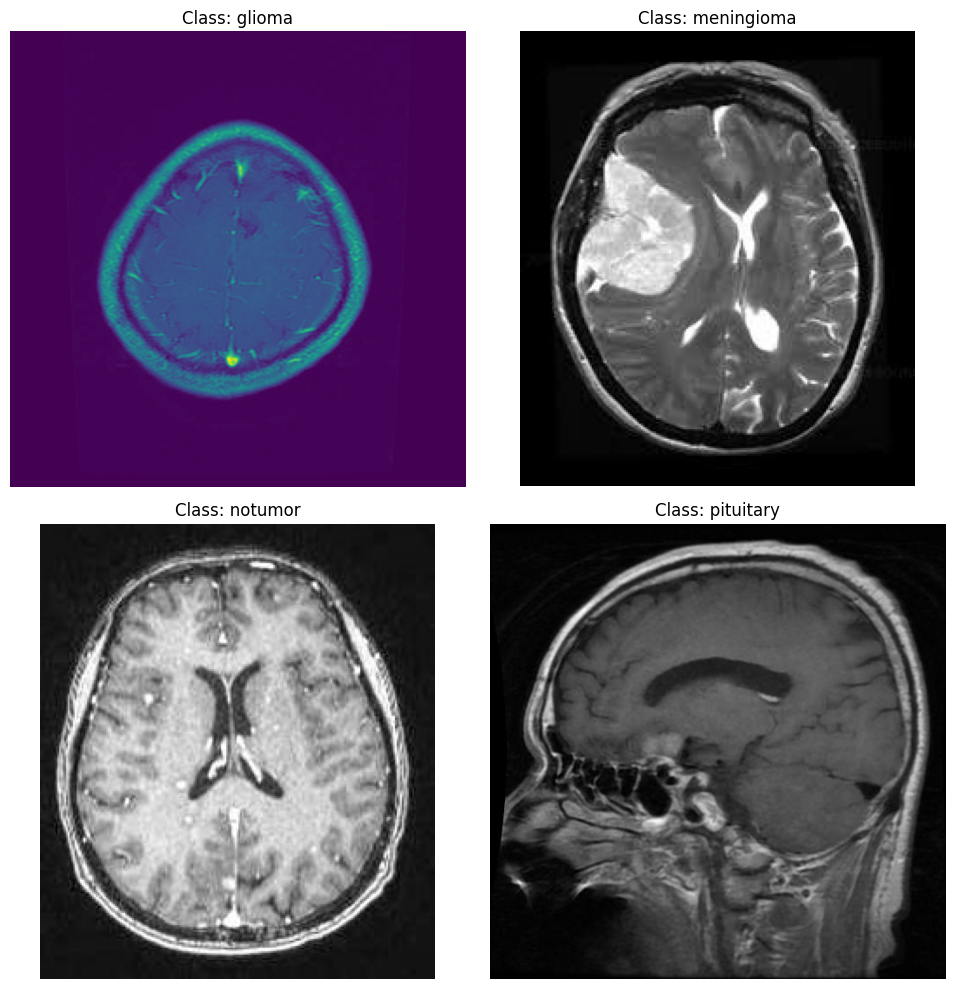

In [6]:
# Check class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Testing Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Display sample images from each class
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(training_dir, class_name)
    image_files = os.listdir(class_dir)
    sample_image = random.choice(image_files)
    image_path = os.path.join(class_dir, sample_image)

    image = Image.open(image_path)
    row, col = i // 2, i % 2
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Class: {class_name}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

**Prepare Data for ANN**

In [7]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened testing data shape: {X_test_flat.shape}")

# One-hot encode the labels
num_classes = len(class_names)
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

Flattened training data shape: (5712, 49152)
Flattened testing data shape: (1311, 49152)


**Build the ANN Model**

In [8]:
# Define the model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_flat.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,331,076 (96.63 MB)

 Trainable params: 25,331,076 (96.63 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [9]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Train the model
history = model.fit(
    X_train_flat, y_train_categorical,
    batch_size=32,
    epochs=50,
    validation_data=(X_test_flat, y_test_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3609 - loss: 3.2674 - val_accuracy: 0.6194 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5998 - loss: 0.9621 - val_accuracy: 0.6888 - val_loss: 0.8125 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5962 - loss: 0.9237 - val_accuracy: 0.7063 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6163 - loss: 0.8623 - val_accuracy: 0.6728 - val_loss: 0.8098 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6551 - loss: 0.8043 - val_accuracy: 0.7048 - val_loss: 0.7337 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6562 - loss: 0.7918 - val_accuracy: 0.7323 - val_loss: 0.6498 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6884 - loss: 0

**Evaluating the Model**

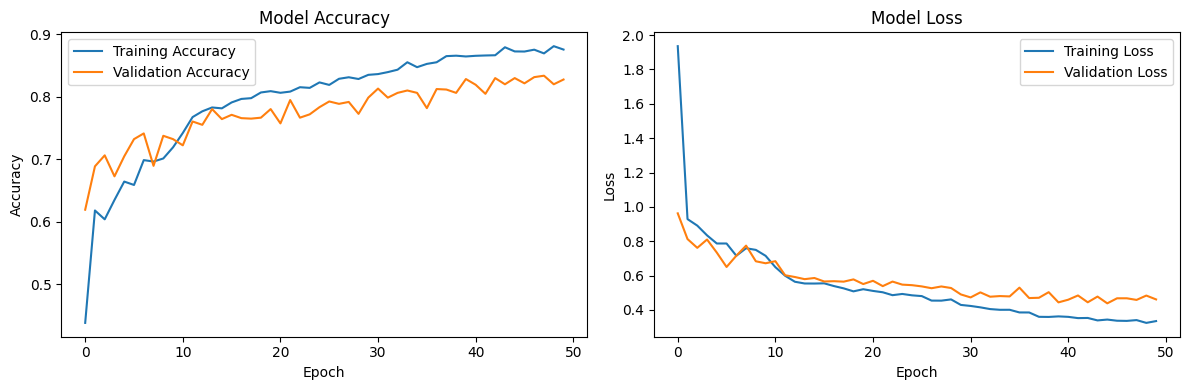

Test Accuracy: 0.8299
Test Loss: 0.4381
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.66      0.90      0.76       300
  meningioma       0.81      0.47      0.59       306
     notumor       0.93      0.96      0.95       405
   pituitary       0.93      0.96      0.95       300

    accuracy                           0.83      1311
   macro avg       0.83      0.82      0.81      1311
weighted avg       0.84      0.83      0.82      1311



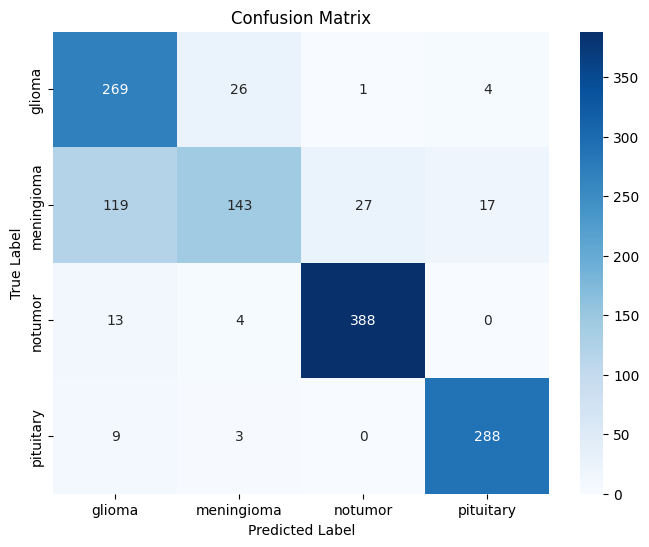

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Make Predictions on Random Images from the Kaggle Dataset**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


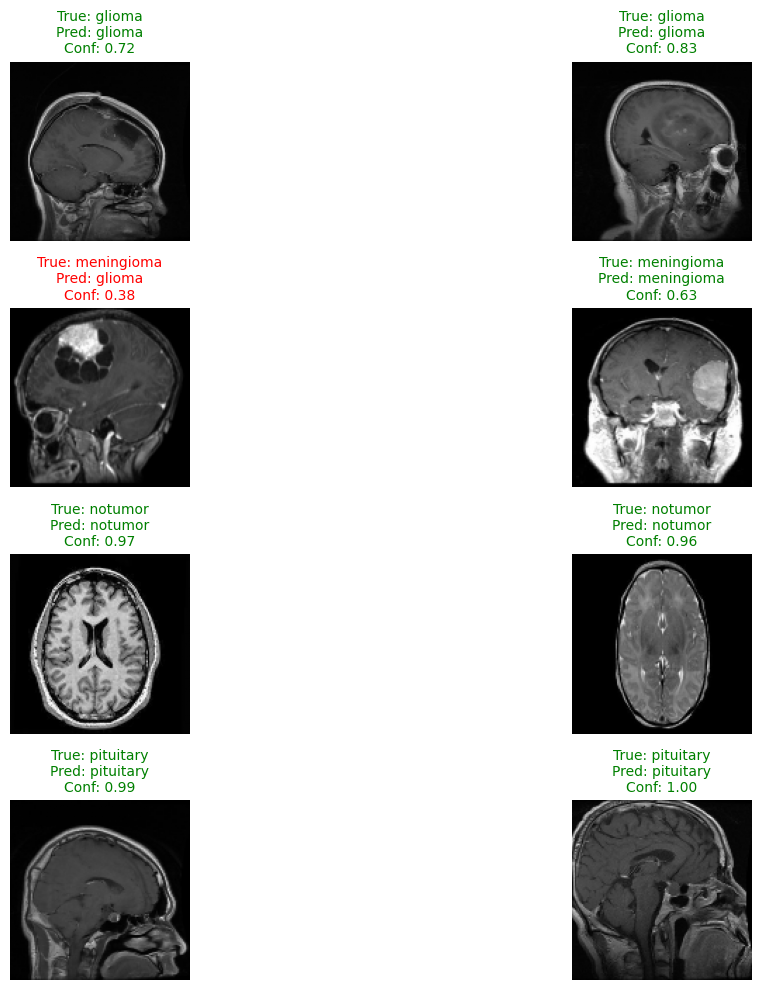


Detailed Predictions on Random Samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


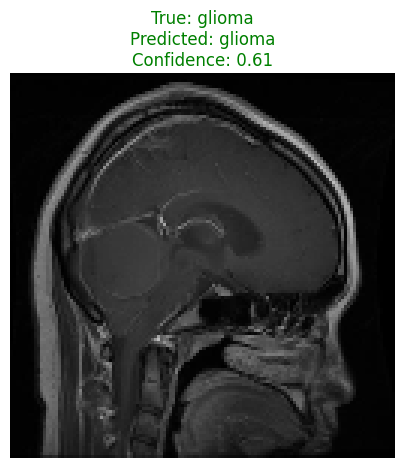

Sample 1:
True Class: glioma
Predicted Class: glioma
Confidence: 0.6113
Correct: Yes
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


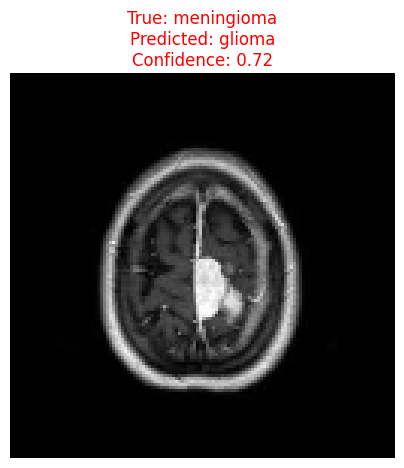

Sample 2:
True Class: meningioma
Predicted Class: glioma
Confidence: 0.7215
Correct: No
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


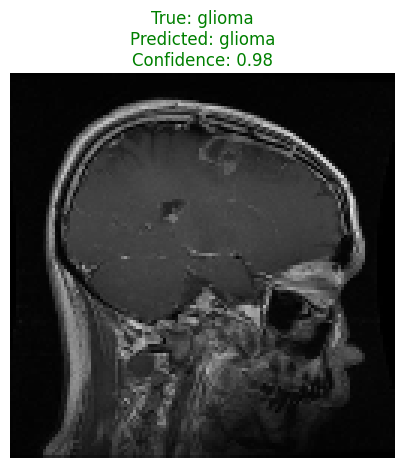

Sample 3:
True Class: glioma
Predicted Class: glioma
Confidence: 0.9764
Correct: Yes
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


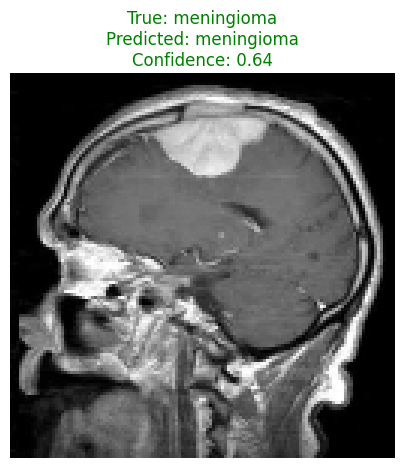

Sample 4:
True Class: meningioma
Predicted Class: meningioma
Confidence: 0.6441
Correct: Yes
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


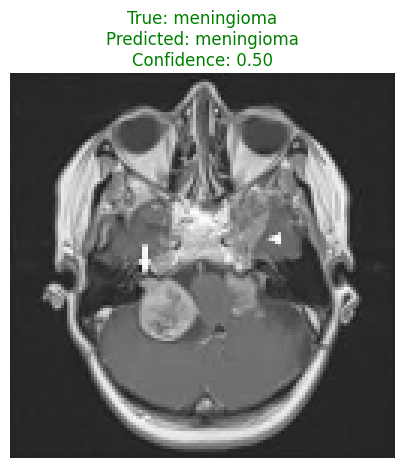

Sample 5:
True Class: meningioma
Predicted Class: meningioma
Confidence: 0.4996
Correct: Yes
------------------------------


In [15]:
# Function to predict on a single image
def predict_tumor(image_path):
    # Preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0

    # Flatten the image
    image_flat = image.reshape(1, -1)

    # Make prediction
    prediction = model.predict(image_flat)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    return predicted_class, confidence, image

# Select random images from each class for prediction
plt.figure(figsize=(15, 10))
num_samples_per_class = 2

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(testing_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    random_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(class_dir, image_file)
        predicted_class, confidence, image = predict_tumor(image_path)

        # Calculate position in the grid
        position = i * num_samples_per_class + j + 1
        plt.subplot(len(class_names), num_samples_per_class, position)
        plt.imshow(image)
        plt.axis('off')

        # Set title color based on correct prediction
        title_color = 'green' if predicted_class == i else 'red'
        plt.title(f'True: {class_name}\nPred: {class_names[predicted_class]}\nConf: {confidence:.2f}',
                 color=title_color, fontsize=10)

plt.tight_layout()
plt.show()

# Detailed prediction on a few random samples
print("\nDetailed Predictions on Random Samples:")
print("="*50)

for i in range(5):  # Predict on 5 random samples
    # Select a random class and image
    random_class = random.choice(class_names)
    class_dir = os.path.join(testing_dir, random_class)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)

        # Make prediction
        predicted_class, confidence, image = predict_tumor(image_path)

        # Display results
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')

        # Set title color based on correct prediction
        title_color = 'green' if predicted_class == class_names.index(random_class) else 'red'
        plt.title(f'True: {random_class}\nPredicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}',
                 color=title_color)
        plt.show()

        # Print detailed information
        print(f"Sample {i+1}:")
        print(f"True Class: {random_class}")
        print(f"Predicted Class: {class_names[predicted_class]}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Correct: {'Yes' if predicted_class == class_names.index(random_class) else 'No'}")
        print("-" * 30)

**Prediction on Random Images from library**

Please upload a brain MRI image for prediction:


Saving Te-pi_0205.jpg to Te-pi_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


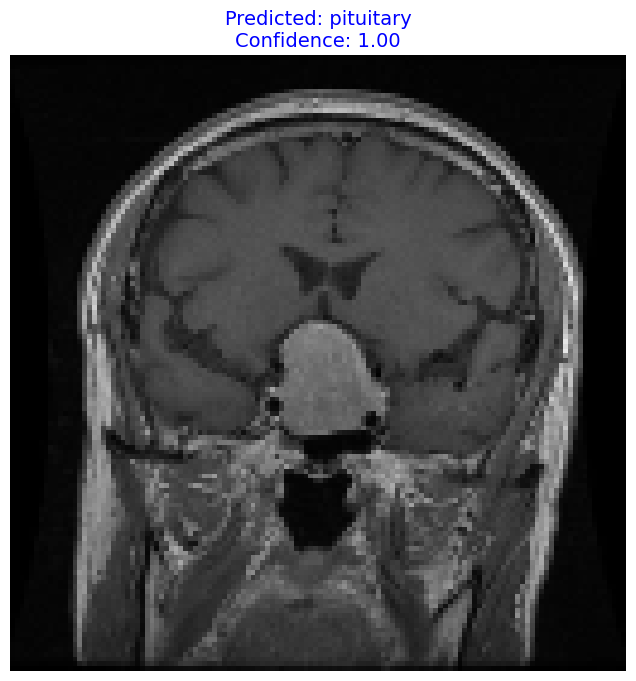

Prediction Results:
Uploaded Image: Te-pi_0205.jpg
Predicted Class: pituitary
Confidence: 0.9995

Confidence for all classes:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
glioma: 0.0000
meningioma: 0.0005
notumor: 0.0001
pituitary: 0.9995


In [18]:
# Function to upload and predict on your own image
def predict_uploaded_image():
    # Upload an image
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Please try again.")
        return

    # Get the uploaded file name
    file_name = list(uploaded.keys())[0]

    # Make prediction
    predicted_class, confidence, image = predict_tumor(file_name)

    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}',
              fontsize=14, color='blue')
    plt.show()

    # Print detailed information
    print("Prediction Results:")
    print("=" * 30)
    print(f"Uploaded Image: {file_name}")
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")

    # Show confidence for all classes
    print("\nConfidence for all classes:")
    image_flat = image.reshape(1, -1)
    prediction = model.predict(image_flat)
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {prediction[0][i]:.4f}")

# Call the function to upload and predict
print("Please upload a brain MRI image for prediction:")
predict_uploaded_image()

In [19]:
# Save the model
model.save('brain_tumor_detection_ann.h5')

# Download the model to your local machine
from google.colab import files
files.download('brain_tumor_detection_ann.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>